In [16]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm

import torch
import cv2
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

In [17]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
from pathlib import Path
from PIL import Image

In [18]:
margin =20
image_size = 160

# Loading face detector
mtcnn = MTCNN(keep_all=False, select_largest=False, post_process=False,
              device=device,margin=margin, image_size=image_size,thresholds=[0.7, 0.7, 0.7])

resnet = InceptionResnetV1(pretrained='casia-webface', device=device).eval()

In [19]:

def extract_face(filename, required_size=(160, 160)):

    image = Image.open(filename)

    image = image.convert('RGB')

    pixels = np.asarray(image)

    face_array = mtcnn(pixels)
    if face_array==None:
        return None
    return face_array.permute(1,2,0).int().numpy()


In [20]:
image = Image.open("100celeb/bollywood_celeb_faces_0/Aamir_Khan/5.jpg")
image.size

(670, 529)

In [ ]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + '/'+ filename
        if (".jpg" not in filename) and (".png" not in filename):
            continue
        face = extract_face(path)
        if face is None:
            continue
        faces.append(face) 
    return faces

def load_dataset(dir):
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path =dir +'/'+subdir
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# loading train dataset
trainX1, trainy1 = load_dataset('100celeb/bollywood_celeb_faces_0')
print(trainX1.shape, trainy1.shape)

trainX2, trainy2 = load_dataset('100celeb/bollywood_celeb_faces_1')
print(trainX2.shape, trainy2.shape)

trainX3, trainy3 = load_dataset('100celeb/bollywood_celeb_faces2')
print(trainX3.shape, trainy3.shape)


In [ ]:
trainX=np.concatenate((trainX1,trainX2,trainX3), axis=0)
trainy=np.concatenate((trainy1,trainy2,trainy3), axis=0)

In [ ]:
trainy.shape

In [ ]:
np.savez_compressed('100_Bollywood_celebrity_faces_dataset.npz',trainX,trainy)

In [21]:
# loading the face dataset
data = np.load('100_Bollywood_celebrity_faces_dataset.npz')
trainX, trainy = data['arr_0'], data['arr_1']
print('Loaded: ', trainX.shape, trainy.shape)

Loaded:  (11803, 160, 160, 3) (11803,)


In [22]:
trainy.shape

(11803,)

In [23]:
from sklearn.model_selection import train_test_split

trainX,testX,trainy,testy=train_test_split(trainX,trainy, test_size=0.33, random_state=42,stratify=trainy)

In [24]:
from torchvision.transforms import ToTensor
tf_img = lambda i: ToTensor()(i).unsqueeze(0).float()
embeddings = lambda input: resnet(input)

In [ ]:
emdTrainX = list()
for face in trainX:

    face=face/255
    t = tf_img(face).to(device)
    emd = embeddings(t).squeeze().cpu().tolist()
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

emdTestX = list()
for face in testX:

    face=face/255
    t = tf_img(face).to(device)
    emd = embeddings(t).squeeze().cpu().tolist()
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

np.savez_compressed('100-Bollywood_celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

In [25]:
data=np.load("100-Bollywood_celebrity-faces-embeddings.npz")

In [26]:
emdTrainX, trainy, emdTestX, testy=data["arr_0"],data["arr_1"],data["arr_2"],data["arr_3"]

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# label encoding targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
#model fitting
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX)
yhat_test = model.predict(emdTestX)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)

print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=7908, test=3895
Accuracy: train=98.672, test=97.047


Expected: Tiger_Shroff
predicted: Tiger_Shroff


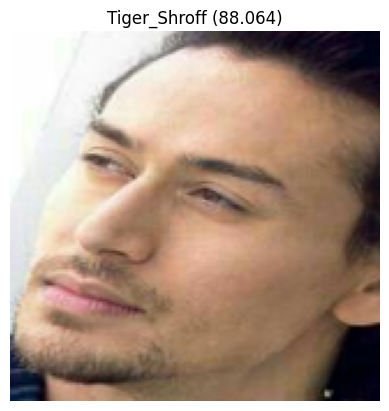

In [73]:
from random import choice
# selecting a random face from test set
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Expected: %s' % random_face_name[0])
print("predicted:",predict_names[0])

plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.axis("off")
plt.show()